In [1]:
import sys
sys.path.insert(1, '/home/elinfi/MasterCode/clustering/class/')

In [2]:
import time
import numpy as np
import seaborn as sns
import cooltools.lib.plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

from time import time
from k_medoids import KMedoids
from cluster_statistics import ClusterStatistics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from data_preparation import DataPreparation
from dissimilarity_matrix import DissimilarityMatrix
from simulate_data import SimulateData

In [3]:
sns.set()
sns.set_style('ticks')

# globally set font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [5]:
resolution = 32000
region = 'chr4:1M-7M'
simulation = SimulateData(resolution, region)

k = 1e3
M = 1e6
start = 1*M
end = 150*M

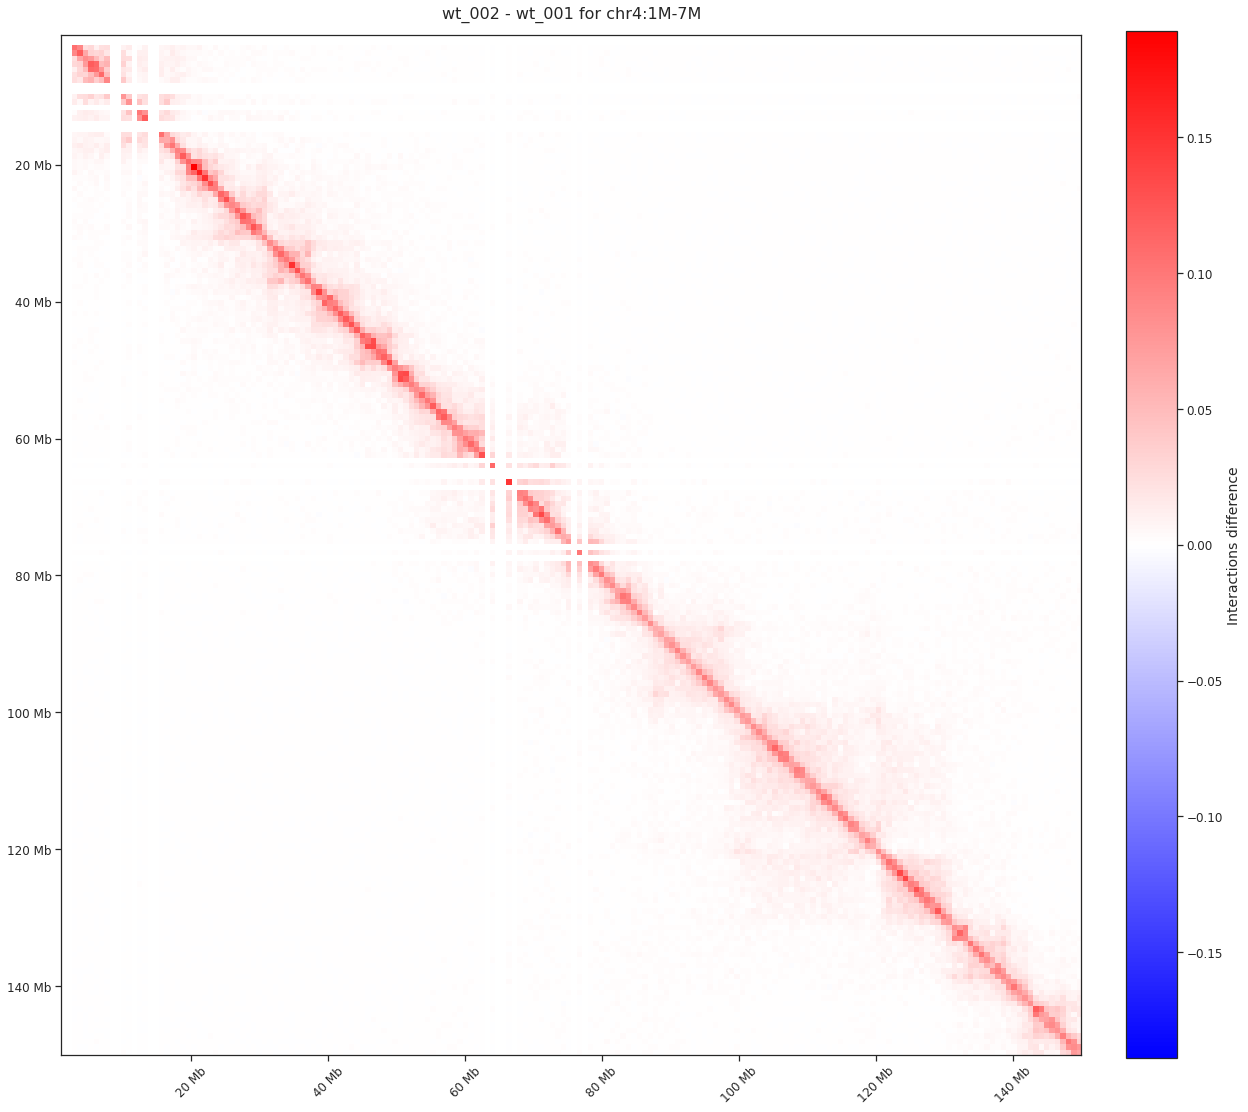

In [6]:
f, axs = plt.subplots(figsize=(20, 20),
                      nrows=1,
                      ncols=1,
                      sharex=True, sharey=False)
ax = axs
vmax = np.nanmax(abs(simulation.matrix))
im = ax.matshow(simulation.matrix,
                vmax=vmax,
                vmin=-vmax,
                cmap='bwr',
                extent=(start, end, end, start))
                #extent=(0,simulation.clr.chromsizes[region], simulation.clr.chromsizes[region], 0))
plt.colorbar(im, fraction=0.046, pad=0.04, label='Interactions difference', ax=ax)
ax.set_title('wt_002 - wt_001 for ' + region, y=1.01)
format_ticks(ax)
plt.savefig('../../Figures/sub_002_001.png')
